# Домашнее задание 5. Градиентный спуск. (10 баллов + 2 балла бонус)

В этом домашнем задании вы реализуете градиентный спуск для линейной регрессии, а также изучите, как он ведёт себя при разных параметрах и с разными функциями потерь.

Правила:

* Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.

* Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.

* Плагиат не допускается. При обнаружении случаев списывания всем участникам нарушения будет выставлено 0 баллов, независимо от того, кто у кого списывал.

* Старайтесь сделать код максимально оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, рассмотренных в курсе.  

In [ ]:
from typing import Iterable, List

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

## Часть 1. Градиентный спуск (5 баллов)

Для начала давайте вспомним самый простой функционал ошибки, который мы применяем в задаче регрессии — **Mean Squared Error (MSE)**:

$$
Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell (\langle x_i, w \rangle - y_i)^2
$$

где $x_i$ — это $i$-ый объект датасета, $y_i$ — правильный ответ для $i$-го объекта, а $w$ — веса нашей линейной модели.

Как мы помним, для линейной модели его можно записать в матричном виде вот так:

$$
Q(w, X, y) = \frac{1}{\ell} || Xw - y ||^2
$$

где $X$ — это матрица объекты-признаки, а $y$ — вектор правильных ответов.

Чтобы воспользоваться методом градиентного спуска, нам нужно посчитать градиент нашего функционала. Для MSE он будет выглядеть так:

$$
\nabla_w Q(w, X, y) = \frac{2}{\ell} X^T(Xw-y)
$$

Ниже приведён базовый класс `BaseLoss`, который мы будем использовать для реализации всех наших лоссов. Менять его **не нужно**. У него есть два абстрактных метода:
1. Метод `calc_loss`, который будет принимать на вход объекты `x`, правильные ответы `y` и веса `w` и вычислять значения лосса.
2. Метод `calc_grad`, который будет принимать на вход объекты `x`, правильные ответы `y` и веса `w` и вычислять градиент функции потерь по параметрам модели.

In [ ]:
import abc


class BaseLoss(abc.ABC):
    """Базовый класс лосса"""

    @abc.abstractmethod
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: число - значения функции потерь
        """
        raise NotImplementedError

    @abc.abstractmethod
    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        raise NotImplementedError

Теперь давайте напишем реализацию этого абстрактного класса: Mean Squared Error лосс.

**Задание 1.1 (5/8 балла):** Реализуйте класс `MSELoss`.

Он должен вычислять лосс и градиент по формулам наверху.

In [ ]:
class MSELoss(BaseLoss):
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: число -- значения функции потерь
        """
        loss = (1 / X.shape[0]) * ((X @ w - y) ** 2).sum()
        return loss

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """

        grad = (2 / X.shape[0]) * X.T @ (X @ w - y)
        return grad

Теперь мы можем создать объект `MSELoss` и при помощи него вычислять значение нашей функции потерь и градиенты:

In [ ]:
# Создадим объект лосса
loss = MSELoss()

# Создадим какой-то датасет
X = np.arange(200).reshape(20, 10)
y = np.arange(20)

# Создадим какой-то вектор весов
w = np.arange(10)

# Выведем значение лосса и градиента на этом датасете с этим вектором весов
print(loss.calc_loss(X, y, w))
print(loss.calc_grad(X, y, w))

# Проверка, что методы реализованы правильно
assert loss.calc_loss(X, y, w) == 27410283.5, "Метод calc_loss реализован неверно"
assert np.allclose(
    loss.calc_grad(X, y, w),
    np.array(
        [
            1163180.0,
            1172281.0,
            1181382.0,
            1190483.0,
            1199584.0,
            1208685.0,
            1217786.0,
            1226887.0,
            1235988.0,
            1245089.0,
        ]
    ),
), "Метод calc_grad реализован неверно"
print("Всё верно!")

27410283.5
[1163180. 1172281. 1181382. 1190483. 1199584. 1208685. 1217786. 1226887.
 1235988. 1245089.]
Всё верно!


Теперь когда у нас есть всё для вычисления градиента, давайте напишем наш градиентный спуск. Напомним, что формула для одной итерации градиентного спуска выглядит следующим образом:

$$
w^{t+1} = w^{t} - \eta \nabla_{w} Q(w^{t}, X, y)
$$

Где $w^t$ — значение вектора весов на $t$-ой итерации, а $\eta$ — параметр learning rate, отвечающий за размер шага.

**Задание 1.2 (5/8 балла):** Реализуйте функцию `gradient_descent`.

Функция должна принимать на вход начальное значение весов линейной модели `w_init`, матрицу объектов-признаков `X`,
вектор правильных ответов `y`, объект функции потерь `loss`, размер шага `lr` и количество итераций `n_iterations`.

Функция должна реализовывать цикл, в котором происходит шаг градиентного спуска (градиенты берутся из `loss` посредством вызова метода `calc_grad`) по формуле выше, и возвращать
траекторию спуска (список из новых значений весов на каждом шаге).

In [ ]:
def gradient_descent(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    n_iterations: int = 100000,
) -> List[np.ndarray]:
    """
    Функция градиентного спуска
    :param w_init: np.ndarray размера (n_feratures,) - начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) - матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) - вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param lr: float -- параметр величины шага, на который нужно домножать градиент
    :param n_iterations: int --сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) - история весов на каждом шаге
    """
    traj = []
    w = w_init
    for i in range(n_iterations):

        traj.append(w)

        grad = loss.calc_grad(X, y, w)

        w = w - lr * grad

    return traj

Теперь создадим синтетический датасет и функцию, которая будет рисовать траекторию градиентного спуска по истории.

In [ ]:
# Создаём датасет из двух переменных и реального вектора зависимости w_true

np.random.seed(1337)

n_features = 2
n_objects = 300
batch_size = 10
num_steps = 43

w_true = np.random.normal(size=(n_features,))

X = np.random.uniform(-5, 5, (n_objects, n_features))
X *= (np.arange(n_features) * 2 + 1)[np.newaxis, :] # разные масштабы признаков
y = X.dot(w_true) + np.random.normal(0, 1, (n_objects))
w_init = np.random.uniform(-2, 2, (n_features))

print(X.shape)
print(y.shape)

(300, 2)
(300,)


In [ ]:
loss = MSELoss()
w_list = gradient_descent(w_init, X, y, loss, 0.01, 100)
print(loss.calc_loss(X, y, w_list[0]))
print(loss.calc_loss(X, y, w_list[-1]))

425.5891768045026
0.8670644395649652


In [ ]:
def plot_gd(w_list: Iterable, X: np.ndarray, y: np.ndarray, loss: BaseLoss):
    """
    Функция для отрисовки траектории градиентного спуска
    :param w_list: Список из объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать лосс при помощи loss.calc_loss(X, y, w)
    """
    w_list = np.array(w_list)
    meshgrid_space = np.linspace(-2, 2, 100)
    A, B = np.meshgrid(meshgrid_space, meshgrid_space)

    levels = np.empty_like(A)
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            w_tmp = np.array([A[i, j], B[i, j]])
            levels[i, j] = loss.calc_loss(X, y, w_tmp)

    plt.figure(figsize=(15, 6))
    plt.title("GD trajectory")
    plt.xlabel(r"$w_1$")
    plt.ylabel(r"$w_2$")
    plt.xlim(w_list[:, 0].min() - 0.1, w_list[:, 0].max() + 0.1)
    plt.ylim(w_list[:, 1].min() - 0.1, w_list[:, 1].max() + 0.1)
    plt.gca().set_aspect("equal")

    # Отображение уровня функции потерь
    CS = plt.contour(
        A, B, levels, levels=np.logspace(0, 1, num=20), cmap=plt.cm.rainbow_r
    )
    CB = plt.colorbar(CS, shrink=0.8, extend="both")

    # Отображение траектории спуска
    plt.scatter(w_list[:, 0], w_list[:, 1])
    plt.plot(w_list[:, 0], w_list[:, 1])

    plt.show()

**Задание 1.3 (5/8 балла):** При помощи функций `gradient_descent` и  `plot_gd` нарисуйте траекторию градиентного спуска для разных значений длины шага (параметра `lr`). Используйте четыре и более различных значений для `lr`.

Сделайте и опишите свои выводы о том, как параметр `lr` влияет на поведение градиентного спуска.

Подсказки:
* Функция `gradient_descent` возвращает историю весов, которую нужно подать в функцию `plot_gd`.
* Хорошие значения для `lr` могут лежать в промежутке от 0.0001 до 0.1.

0.001


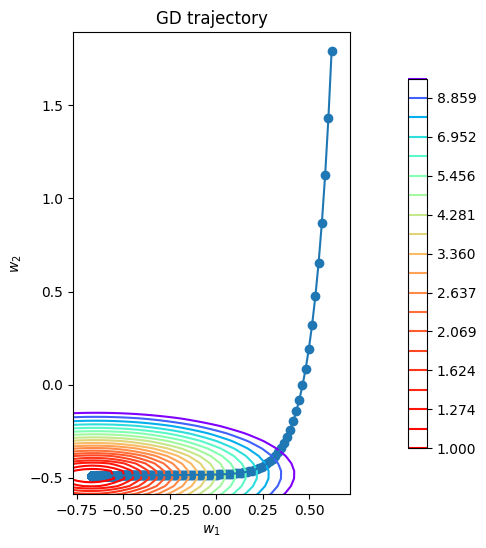


0.002


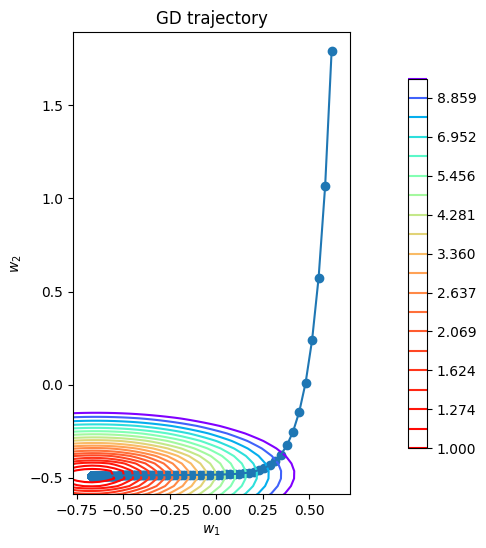


0.004


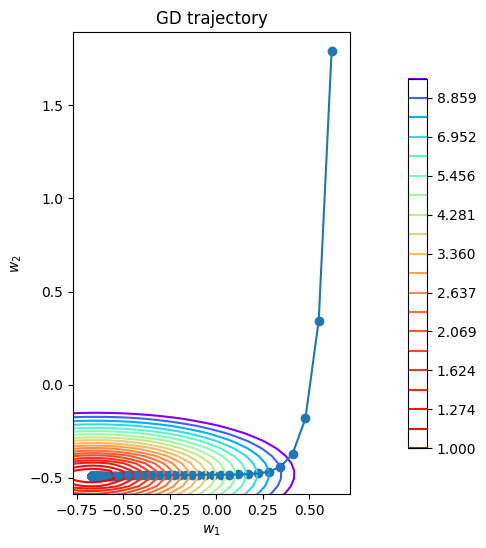


0.008


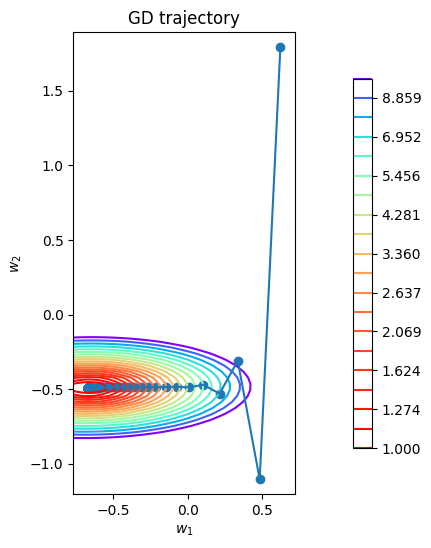


0.01


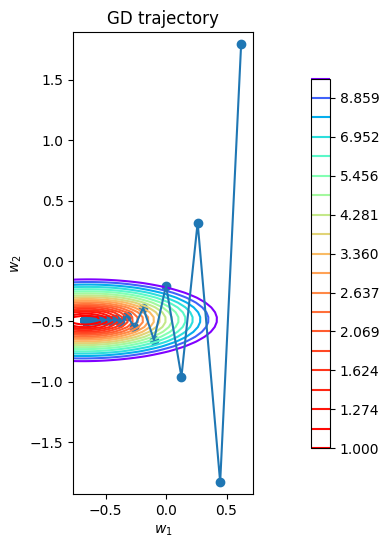

In [ ]:
lr_list = [0.001, 0.002, 0.004, 0.008, 0.01]
for lr in lr_list:
    w_list = gradient_descent(w_init, X, y, loss, lr)
    print(lr)
    plot_gd(w_list, X, y, loss)
    print()

При слишком маленьком lr алгоритм сходится медленно, но зато хорошо))

При увеличении lr сходимость ускоряется, но траектория может стать зигзагообразной

Слишком большой lr приводит к тому, что вообще не сойдется из за слишком большого шага

Теперь реализуем стохастический градиентный спуск.

**Задание 1.4 (5/8 балла):** Реализуйте функцию `stochastic_gradient_descent`.

Функция должна принимать все те же параметры, что и функция `gradient_descent`, но ещё параметр `batch_size`, отвечающий за размер батча.

Функция должна как и раньше реализовывать цикл, в котором происходит шаг градиентного спуска, но на каждом шаге считать градиент не по всей выборке `X`, а только по случайно выбранной части.

Подсказка: для выбора случайной части можно использовать [`np.random.choice`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html) с правильным параметром `size`, чтобы выбрать случайные индексы, а потом проиндексировать получившимся массивом массив `X`:
```
batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
batch = X[batch_indices]
```

In [ ]:
def stochastic_gradient_descent(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    batch_size: int,
    n_iterations: int = 1000,
) -> List[np.ndarray]:
    """
    Функция градиентного спуска
    :param w_init: np.ndarray размера (n_feratures,) -- начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param lr: float -- параметр величины шага, на который нужно домножать градиент
    :param batch_size: int -- размер подвыборки, которую нужно семплировать на каждом шаге
    :param n_iterations: int -- сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    """
    traj = []
    w = w_init
    for i in range(n_iterations):

        traj.append(w)

        batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)

        X_batch = X[batch_indices]
        y_batch = y[batch_indices]

        grad = loss.calc_grad(X_batch, y_batch, w)
        w = w - lr * grad

    return traj

**Задание 1.5 (5/8 балла):** При помощи функций `stochastic_gradient_descent` и  `plot_gd` нарисуйте траекторию градиентного спуска для разных значений длины шага (параметра `lr`) и размера подвыборки (параметра `batch_size`). Используйте не менее четырёх разных значений для `lr` и `batch_size`.

Сделайте и опишите свои выводы о том, как параметры  `lr` и `batch_size` влияют на поведение стохастического градиентного спуска. Как отличается поведение стохастического градиентного спуска от обычного? Что происходит при малых и больших `batch_size`?

Обратите внимание, что в нашем датасете всего 300 объектов, так что `batch_size` больше этого числа не будет иметь смысла.

lr = 0.001, batch_size = 10


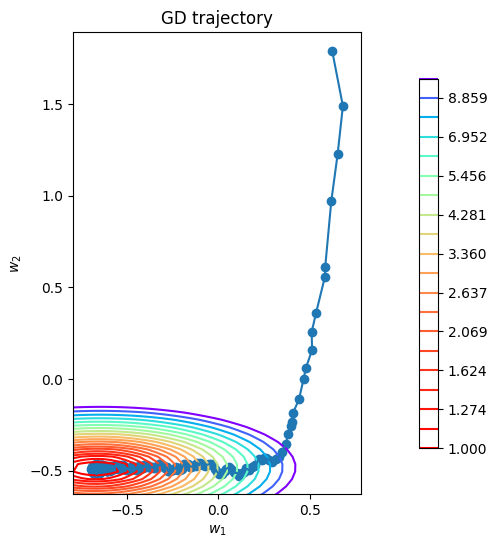


lr = 0.001, batch_size = 30


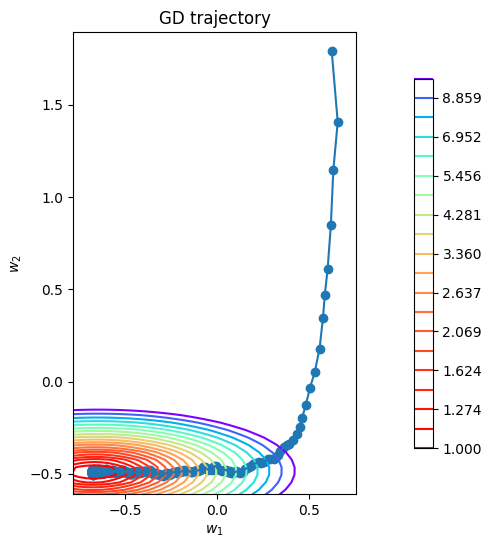


lr = 0.001, batch_size = 50


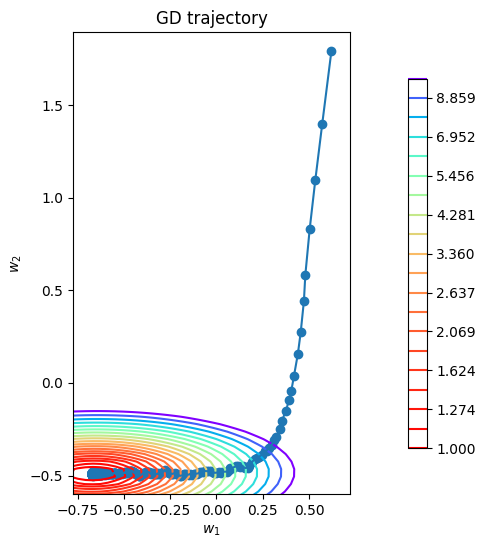


lr = 0.001, batch_size = 100


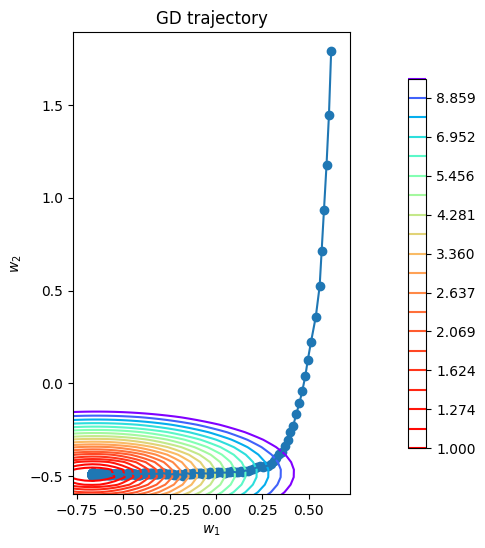


lr = 0.002, batch_size = 10


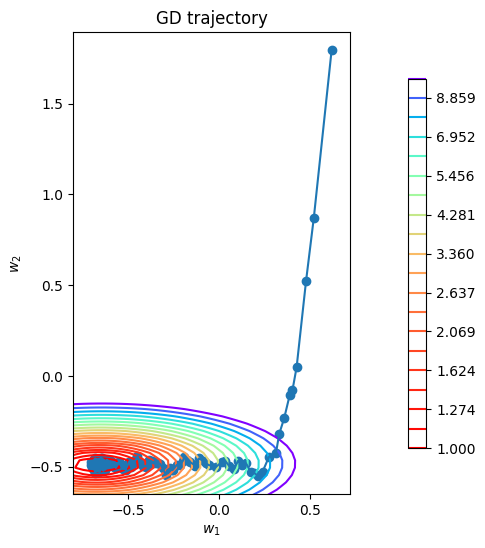


lr = 0.002, batch_size = 30


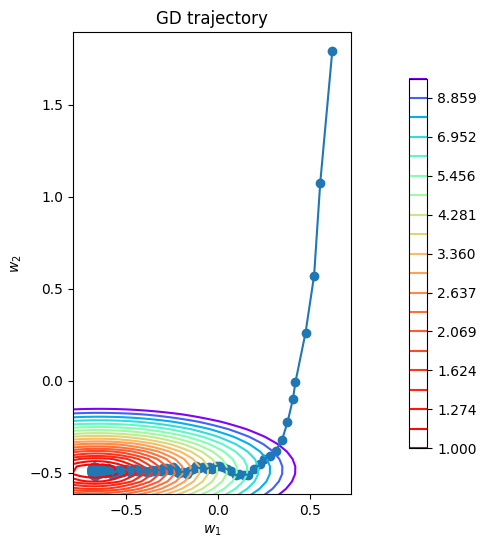


lr = 0.002, batch_size = 50


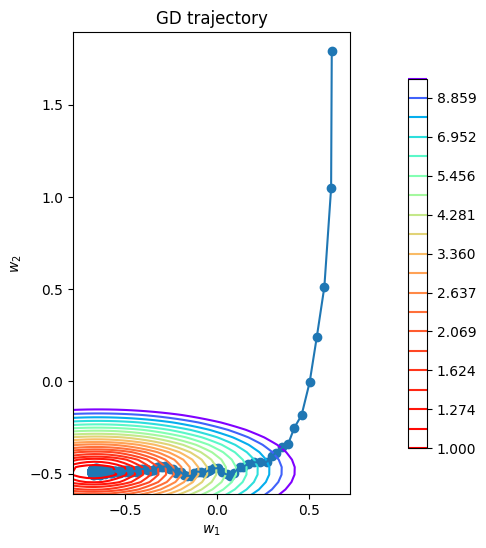


lr = 0.002, batch_size = 100


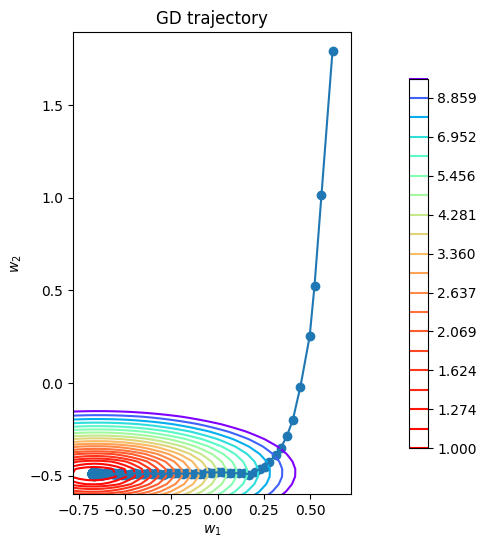


lr = 0.004, batch_size = 10


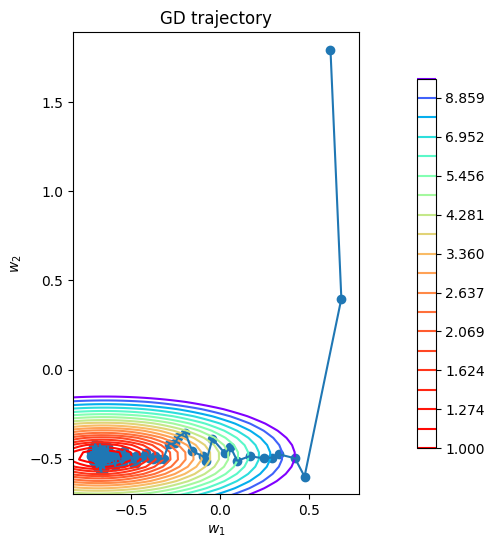


lr = 0.004, batch_size = 30


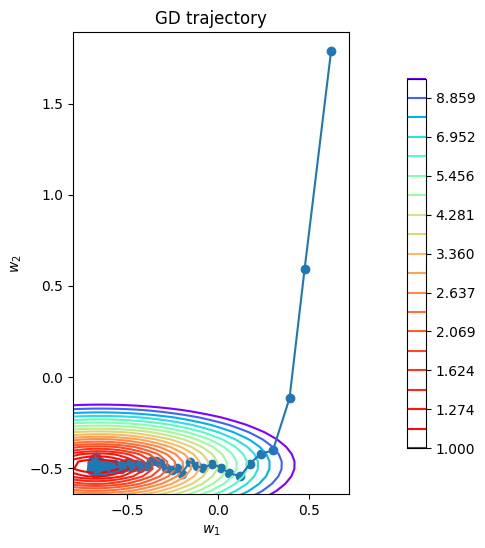


lr = 0.004, batch_size = 50


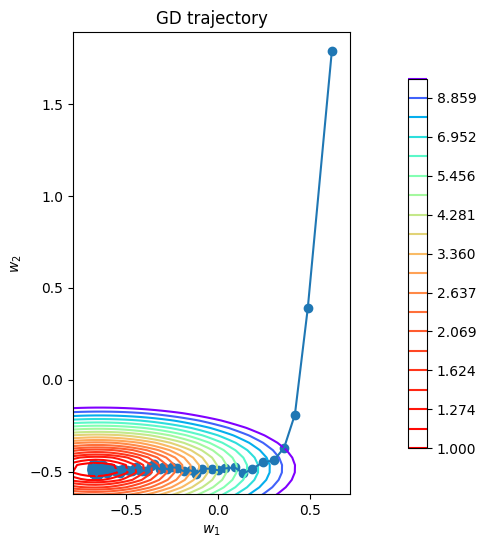


lr = 0.004, batch_size = 100


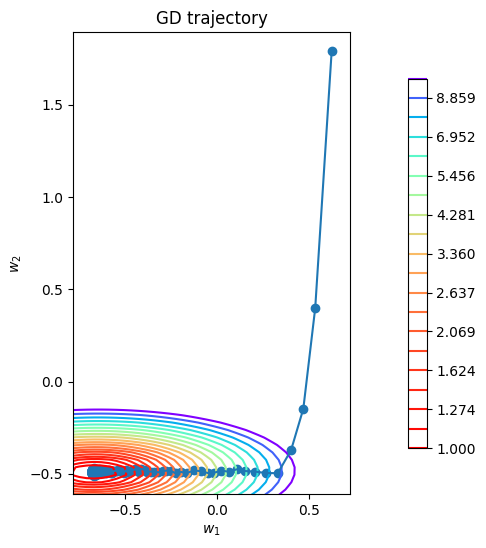


lr = 0.008, batch_size = 10


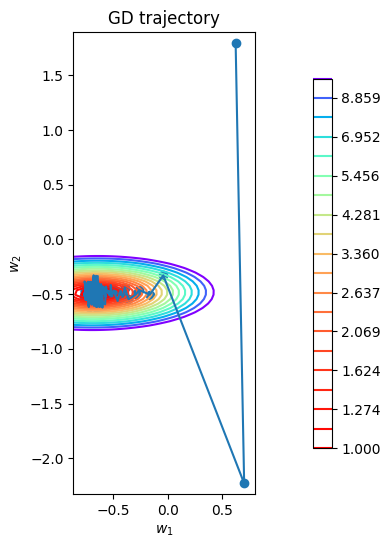


lr = 0.008, batch_size = 30


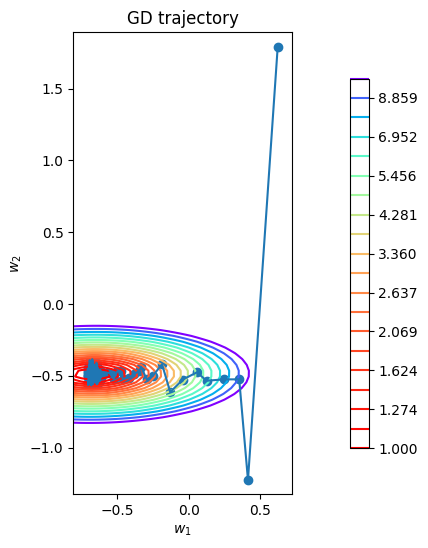


lr = 0.008, batch_size = 50


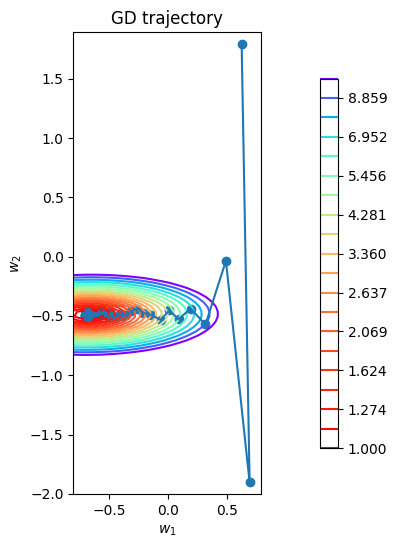


lr = 0.008, batch_size = 100


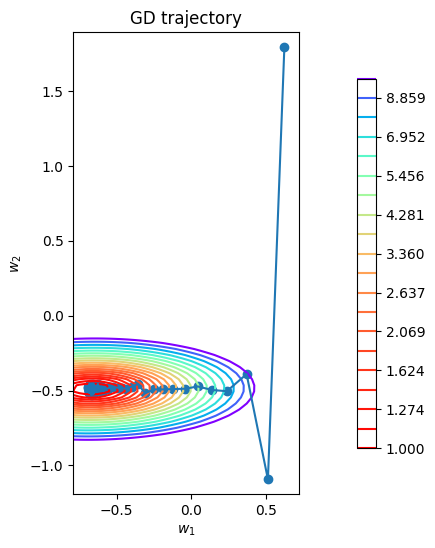

In [ ]:
lr_list = [0.001, 0.002, 0.004, 0.008]
batch_sizes = [10, 30, 50, 100]
for lr in lr_list:
    for batch_size in batch_sizes:
        print(f"lr = {lr}, batch_size = {batch_size}")
        w_list = stochastic_gradient_descent(w_init, X, y, loss, lr, batch_size)
        plot_gd(w_list, X, y, loss)
        print()

Если lr маленький и размер батча тоже маленький, то траектория получается не очень плавной нестабильной с колебаниями

А вот если шаг большой и батч маленький то траектория превращается в большие зигзаги, веса прыгают сильно, и траектория может улететь

Чем больше батч тем плавнее траектория

Вы могли заметить, что поведение градиентного спуска, особенно стохастической версии, очень сильно зависит от размера шага.

Как правило, в начале спуска мы хотим делать большие шаги, чтобы поскорее подойти поближе к минимуму, а позже мы уже хотим делать шаги маленькие, чтобы точнее этого минимума достигнуть и не "перепрыгнуть" его.

Чтобы достичь такого поведения мы можем постепенно уменьшать длину шага с увеличением номера итерации. Сделать это можно, например, вычисляя на каждой итерации длину шага по следующей формуле:

$$
    \eta_t
    =
    \lambda
    \left(
        \frac{s_0}{s_0 + t}
    \right)^p
$$

где $\eta_t$ — длина шага на итерации $t$, $\lambda$ — начальная длина шага (параметр `lr` у нас), $s_0$ и $p$ — настраиваемые параметры.

**Задание 1.6 (5/8 балла):** Реализуйте функцию `stochastic_gradient_descent` на этот раз с затухающим шагом по формуле выше. Параметр $s_0$ возьмите равным 1. Параметр $p$ возьмите из нового аргумента функции `p`.

In [ ]:
def stochastic_gradient_descent_new(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    batch_size: int,
    p: float,
    n_iterations: int = 1000,
) -> List[np.ndarray]:
    """
    Функция градиентного спуска
    :param w_init: np.ndarray размера (n_feratures,) - начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) - матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) - вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param lr: float - параметр величины шага, на который нужно домножать градиент
    :param batch_size: int - размер подвыборки, которую нужно семплировать на каждом шаге
    :param p: float - значение степени в формуле затухания длины шага
    :param n_iterations: int - сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) - история весов на каждом шаге
    """
    traj = []
    w = w_init
    for i in range(1, n_iterations + 1):
        nt = lr * (1 / (1 + i)) ** p

        traj.append(w)
        batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)

        X_batch = X[batch_indices]
        y_batch = y[batch_indices]

        grad = loss.calc_grad(X_batch, y_batch, w)
        w = w - nt * grad

    return traj

**Задание 1.7 (5/8 балла):** При помощи новой функции `stochastic_gradient_descent` и функции `plot_gd` нарисуйте траекторию градиентного спуска для разных значений параметра `p`. Используйте не менее четырёх разных значений для `p`. Хорошими могут быть значения, лежащие в промежутке от 0.1 до 1.
Параметр `lr` возьмите равным 0.01, а параметр `batch_size` равным 10.

Сделайте и опишите свои выводы о том, как параметр `p` влияет на поведение стохастического градиентного спуска. Что происходит при маленьком или большом значении p?

p=0.1


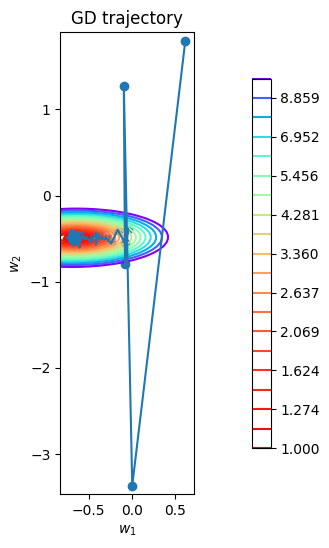


p=0.3


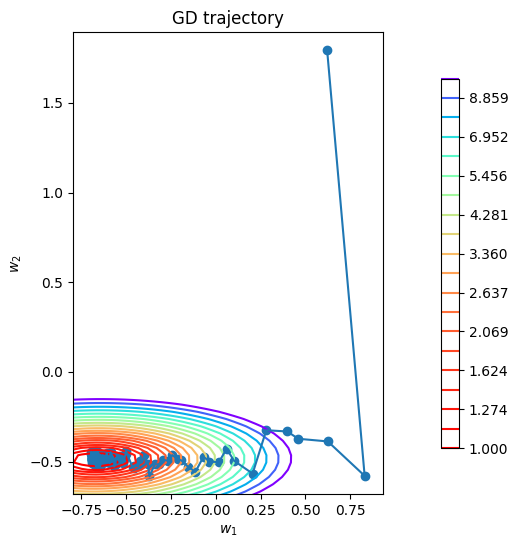


p=0.5


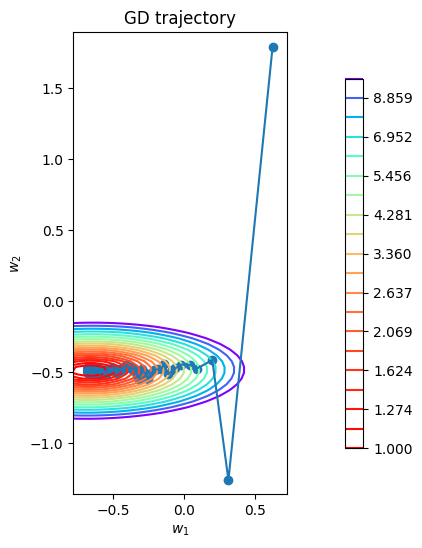


p=1.0


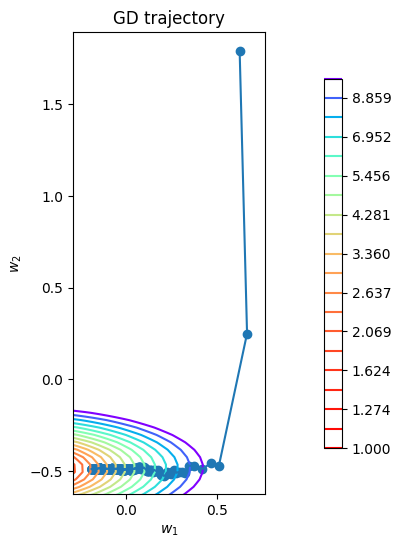

In [ ]:
lr = 0.01
batch_size = 10
p_values = [0.1, 0.3, 0.5, 1.0]


for p in p_values:
    print(f"p={p}")
    w_history = stochastic_gradient_descent_new(w_init, X, y, loss, lr, batch_size, p)
    plot_gd(w_history, X, y, loss)
    print()

т к у нас lr достаточно большой (0.1), а при малом значении p затухание шага происходит медленно и длина шага долго остаётся близкой к начальному lr

Из за этого траектория очень сильно колеблется

С увеличением p затухание усиливается и траектория становится более плавной, но при сишком большом p (1) Градиент слишком быстро потух и траектория не достигла минимума

**Задание 1.8 (5/8 балла):** Сравните сходимость обычного градиентного спуска и стохастичекой версии:
Нарисуйте график зависимости значения лосса (его можно посчитать при помощи метода `calc_loss`, используя $x$ и $y$ из датасета и $w$ с соответствующей итерации) от номера итерации для траекторий, полученных при помощи обычного и стохастического градиентного спуска с одинаковыми параметрами. Параметр `batch_size` возьмите равным 10.

Видно ли на данном графике преимущество SGD? Почему?

In [ ]:
lr = 0.01
batch_size = 10


w_gd = gradient_descent(w_init, X, y, loss, lr, n_iterations=100)
loss_gd = [loss.calc_loss(X, y, w) for w in w_gd]


w_sgd = stochastic_gradient_descent(w_init, X, y, loss, lr, batch_size, n_iterations=100)
loss_sgd = [loss.calc_loss(X, y, w) for w in w_sgd]

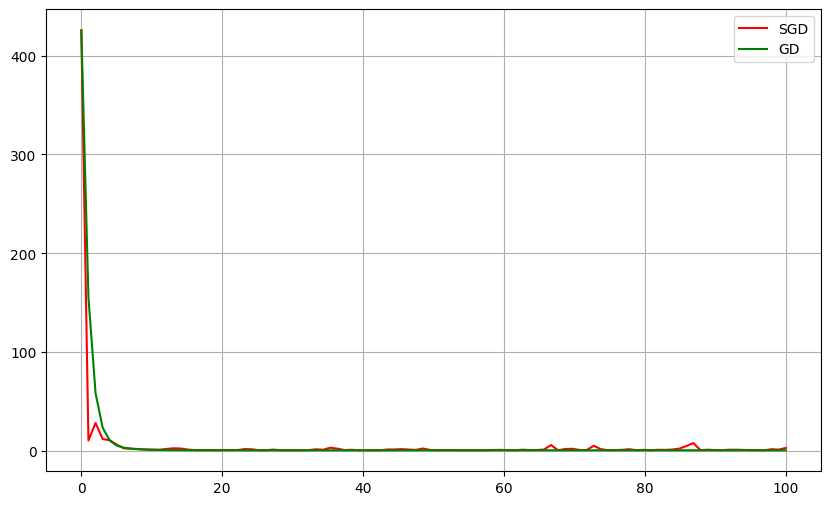

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(0,len(loss_sgd),len(loss_sgd)) ,loss_sgd, color='red' ,label="SGD")
plt.plot(np.linspace(0,len(loss_gd),len(loss_gd)),loss_gd, color='green', label="GD")
plt.legend()
plt.grid(True)

Тут у SGD не видны преимущества потому что на графике они сравниваются по итерациям, хотя время выполнения итерации и память затраченная на одну итерацию может очень сильно отличатся

## Часть 2. Линейная регрессия (5 баллов)

Теперь давайте напишем наш класс для линейной регрессии. Он будет использовать интерфейс, знакомый нам из библиотеки `sklearn`.

В методе `fit` мы будем подбирать веса `w` при помощи градиентного спуска нашим методом `gradient_descent`.

В методе `predict` мы будем применять нашу регрессию к датасету.

**Задание 2.1 (5/8 балла):** Допишите код в методах `fit` и `predict` класса `LinearRegression`.

В методе `fit` вам нужно как-то инициализировать веса `w`, применить `gradient_descent` и сохранить последнюю `w` из траектории.

В методе `predict` вам нужно применить линейную регрессию и вернуть вектор ответов.

Обратите внимание, что объект лосса передаётся в момент инициализации и хранится в `self.loss`. Его нужно использовать в `fit` для `gradient_descent`.

In [ ]:
class LinearRegression:
    def __init__(self, loss: BaseLoss, lr: float = 0.1) -> None:
        self.loss = loss
        self.lr = lr

    def fit(self, X: np.ndarray, y: np.ndarray) -> "LinearRegression":
        X = np.asarray(X)
        y = np.asarray(y)
        # Добавляем столбец из единиц для константного признака
        X = np.hstack([X, np.ones([X.shape[0], 1])])

        self.w = np.zeros(X.shape[1])

        self.w = gradient_descent(X=X, y=y, w_init=self.w, loss=self.loss, lr=self.lr)[-1]

        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        # Проверяем, что регрессия обучена, то есть, что был вызван fit и в нём был установлен атрибут self.w
        assert hasattr(self, "w"), "Linear regression must be fitted first"
        # Добавляем столбец из единиц для константного признака
        X = np.hstack([X, np.ones([X.shape[0], 1])])

        return X @ self.w

Теперь у нас есть наш класс линейной регрессии. Более того, мы можем управлять тем, какую функцию потерь мы оптимизируем, просто передавая разные классы в параметр `loss` при инициализации.

Пока у нас нет никаких классов кроме `MSELoss`, но скоро они появятся.

Для `MSELoss` мы бы создавали наш объект линейной регрессии, например, так:

In [ ]:
linear_regression = LinearRegression(MSELoss())

Применим нашу регрессию на реальном датасете. Загрузим датасет с машинами, который был у вас на семинарах:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

X_raw = pd.read_csv(
    "/content/drive/MyDrive/IAD/5/cars_data.csv",
    header=None,
    na_values=["?"],
    skiprows=1,
    index_col=0
)
X_raw = X_raw[~X_raw[26].isna()].reset_index(drop=True)
X_raw.head()

,1,2,3,4,5,6,7,8,9,10,...,17,18,19,20,21,22,23,24,25,26
0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,2,164.0,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,164.0,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0


In [ ]:
y = X_raw[26]
X_raw = X_raw.drop(26, axis=1)

**Задание 2.2 (5/8 балла):** Как обычно обработайте датасет всеми нужными методами, чтобы на нём можно было обучать линейную регрессию:

* Разделите датасет на обучающую и тестовую выборку
* Заполните пропуски
* Нормализуйте числовые признаки
* Закодируйте категориальные переменные

In [ ]:
X_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1       201 non-null    int64  
 1   2       164 non-null    float64
 2   3       201 non-null    object 
 3   4       201 non-null    object 
 4   5       201 non-null    object 
 5   6       199 non-null    object 
 6   7       201 non-null    object 
 7   8       201 non-null    object 
 8   9       201 non-null    object 
 9   10      201 non-null    float64
 10  11      201 non-null    float64
 11  12      201 non-null    float64
 12  13      201 non-null    float64
 13  14      201 non-null    int64  
 14  15      201 non-null    object 
 15  16      201 non-null    object 
 16  17      201 non-null    int64  
 17  18      201 non-null    object 
 18  19      197 non-null    float64
 19  20      197 non-null    float64
 20  21      201 non-null    float64
 21  22      199 non-null    float64
 22  23

In [ ]:
RANDOM_STATE = 42

In [ ]:
# Делим датасет
X_train, X_test, y_train, y_test = train_test_split(X_raw, y, test_size=0.25, random_state=RANDOM_STATE)

# Отделяем категориальные и числовые
num_features = X_train.select_dtypes(include=['int64', 'float64']).columns
cat_features = X_train.select_dtypes(include=['object']).columns

# Заполняем пропуски
X_train[num_features] = X_train[num_features].fillna(X_train[num_features].mean())
X_test[num_features] = X_test[num_features].fillna(X_train[num_features].mean())

X_train[cat_features] = X_train[cat_features].fillna(X_train[cat_features].mode().iloc[0])
X_test[cat_features] = X_test[cat_features].fillna(X_train[cat_features].mode().iloc[0])

# Нормализуем
scaler = StandardScaler()
X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])

# КОдируем
encoder = OneHotEncoder(drop = 'first', sparse_output=False, handle_unknown='ignore')
X_train_encoded = encoder.fit_transform(X_train[cat_features])
X_test_encoded = encoder.transform(X_test[cat_features])

In [ ]:
cat_features = cat_features.astype(str)
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out(cat_features), index=X_train.index)
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names_out(cat_features), index=X_test.index)

# Объединяем числовые и категориальные
X_train_final = pd.concat([X_train[num_features], X_train_encoded_df], axis=1)
X_test_final = pd.concat([X_test[num_features], X_test_encoded_df], axis=1)


In [ ]:
X_train_final.head()

,1,2,10,11,12,13,14,17,19,20,...,16_three,16_twelve,16_two,18_2bbl,18_4bbl,18_idi,18_mfi,18_mpfi,18_spdi,18_spfi
174,1.832353,2.342994e+00,0.710719,0.783748,0.959626,-0.761609,0.876394,1.140151,-0.191298,0.293788,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,1.011896,-4.405276e-16,0.175262,0.259068,0.257705,-0.315828,-0.083729,0.270881,-0.492056,0.449136,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
126,-0.629017,-4.405276e-16,-0.463833,0.614496,0.357980,0.535206,0.063667,0.171536,0.523001,2.002618,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
117,0.191440,1.010021e+00,-0.878380,-1.433448,-0.995725,-1.328965,-1.189202,-0.871588,-1.319140,-0.079048,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
73,1.011896,1.227016e+00,-0.878380,-1.433448,-0.694902,-1.247914,-1.289513,-0.821915,-1.319140,-0.079048,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


**Задание 2.3 (5/8 балла):** Обучите написанную вами линейную регрессию на обучающей выборке

In [ ]:
linear_regression.fit(X_train_final, y_train)

**Задание 2.4 (5/8 балла):** Посчитайте ошибку обученной регрессии на обучающей и тестовой выборке при помощи метода `mean_squared_error` из `sklearn.metrics`.

In [ ]:
from sklearn.metrics import mean_squared_error

# Предсказываем
y_train_pred = linear_regression.predict(X_train_final)
y_test_pred = linear_regression.predict(X_test_final)

# Считаем MSE
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print(f"Train MSE: {mse_train:.4f}")
print(f"Test MSE: {mse_test:.4f}")

Train MSE: 1352483.8176
Test MSE: 10381695.3599


Наша модель переобучилась. Давайте как обычно в такой ситуации добавим к ней L2 регуляризацию. Для этого нам нужно написать новый класс лосса.

Формула функции потерь для MSE с L2 регуляризацией выглядит так:
$$
Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell (\langle x_i, w \rangle - y_i)^2 + \lambda ||w||^2
$$

Или в матричном виде:

$$
Q(w, X, y) = \frac{1}{\ell} || Xw - y ||^2 + \lambda ||w||^2
$$

Где $\lambda$ — коэффициент регуляризации.

Градиент выглядит так:

$$
\nabla_w Q(w, X, y) = \frac{2}{\ell} X^T(Xw-y) + 2 \lambda w
$$

**Задание 2.5 (5/8 балла):** Реализуйте класс `MSEL2Loss`.

Он должен вычислять лосс и градиент по формулам выше.

Подсказка: обратите внимание, что последний элемент вектора `w` — это bias (в классе `LinearRegression` к матрице `X` добавляется колонка из единиц — константный признак). Как мы знаем из лекций и семинаров, bias регуляризовать не нужно. Поэтому не забудьте убрать последний элемент из `w` при подсчёте слагаемого $\lambda||w||^2$ в `calc_loss` и занулить его при подсчёте слагаемого $2 \lambda w$ в `calc_grad`.

In [ ]:
class MSEL2Loss(BaseLoss):
    def __init__(self, coef: float = 1.0):
        """
        :param coef: коэффициент регуляризации (лямбда в формуле)
        """
        self.coef = coef

    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета. Последний признак константный.
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии. Последний вес -- bias.
        :output: число -- значения функции потерь
        """
        loss = (1 / X.shape[0]) * ((X @ w - y) ** 2).sum()

        # не трогаем последний вес
        l2 = self.coef * np.sum(w[:-1] ** 2)

        return loss + l2

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :output: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        grad = (2 / X.shape[0]) * X.T @ (X @ w - y)

        grad[:-1] += 2 * self.coef * w[:-1]

        return grad

Теперь мы можем использовать лосс с l2 регуляризацией в нашей регрессии, например, так:

In [ ]:
linear_regression = LinearRegression(MSEL2Loss(0.1))

**Задание 2.6 (5/8 балла):** Обучите регрессию с лоссом `MSEL2Loss`. Подберите хороший коэффициент регуляризации и добейтесь улучшения результата на тестовой выборке. Сравните результат на обучающей и тестовой выборке с регрессией без регуляризации.

In [ ]:
coefs = [0, 0.001, 0.005, 0.01, 0.01]
for coef in coefs:
    linear_regression = LinearRegression(MSEL2Loss(coef))
    linear_regression.fit(X_train_final, y_train)

    # Предсказываем
    y_train_pred = linear_regression.predict(X_train_final)
    y_test_pred = linear_regression.predict(X_test_final)

    # Считаем MSE
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)

    print(f"coef: {coef}")
    print(f"Train MSE: {mse_train:.4f}")
    print(f"Test MSE: {mse_test:.4f}")
    print()

coef: 0
Train MSE: 1352483.8176
Test MSE: 10381695.3599

coef: 0.001
Train MSE: 1599884.4087
Test MSE: 6293536.2625

coef: 0.005
Train MSE: 2112812.3940
Test MSE: 7716472.6843

coef: 0.01
Train MSE: 2548563.4934
Test MSE: 9322418.6180

coef: 0.01
Train MSE: 2548563.4934
Test MSE: 9322418.6180



Добавление L2-регуляризации улучшило качество модели на тестовой выборке

Наилучший результат достигнут при 0.001 -  ошибка на тесте снизилась почти вдвое в сравненнии с моделью без регуляризации

В нашем датасете могут быть выбросы. На семинаре вам рассказывали, что с выбросами хорошо помогает бороться Huber Loss. Вдали от нуля он работает как Mean Absolute Error и не реагирует на выбросы так сильно, как MSE. Давайте его реализуем и применим в нашей регрессии.

Напомним, что функция потерь Huber Loss'а  выглядит так:


$$
    Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell \phi_\varepsilon (\langle x_i, w \rangle - y_i)
$$
$$
    \phi_\varepsilon(z) = \begin{cases} \frac 1 2 z^2, - \varepsilon < z < \varepsilon, \\\varepsilon (|z| - \frac 1 2 \varepsilon), иначе \\ \end{cases}
$$


А градиент так:
$$
    \nabla_w Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell x_i \nabla_z \phi_\varepsilon (\langle x_i, w \rangle - y_i)
$$
$$
    \nabla_z \phi_\varepsilon(z) = \begin{cases} z, - \varepsilon < z < \varepsilon, \\\varepsilon \text{ sign}(z), иначе \\ \end{cases}
$$

**Задание 2.7 (5/8 балла):** Реализуйте класс `HuberLoss`.

Он должен вычислять лосс и градиент по формулам выше.

In [ ]:
class HuberLoss(BaseLoss):
    def __init__(self, eps: float) -> None:
        """
        :param eps: параметр huber loss из формулы
        """
        self.eps = eps

    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :output: число -- значения функции потерь
        """
        err = X @ w - y
        huber = np.abs(err) <= self.eps

        mse = 0.5 * (err[huber] ** 2)
        mae = self.eps * (np.abs(err[~huber]) - 0.5 * self.eps)

        return (1 / X.shape[0] ) * np.sum(np.concatenate([mse, mae]))

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :output: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        err = X @ w - y
        huber = np.abs(err) <= self.eps
        grad = np.zeros_like(w)

        # ошибка < eps
        grad += X[huber].T @ err[huber]

        # ошибка > eps
        grad += X[~huber].T @ (self.eps * np.sign(err[~huber]))

        return (1 / X.shape[0] ) * grad

**Задание 2.8 (5/8 балла):** Обучите регрессию с лоссом `HuberLoss`. Сравните результат на обучающей и тестовой выборке с регрессией, обученной c `MSELoss`.

In [ ]:
eps = [5.0, 10.0, 50.0, 75.0, 100.0]
for ep in eps:
    linear_regression = LinearRegression(HuberLoss(ep))
    linear_regression.fit(X_train_final, y_train)

    # Предсказываем
    y_train_pred = linear_regression.predict(X_train_final)
    y_test_pred = linear_regression.predict(X_test_final)

    # Считаем MSE
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)

    print(f"eps: {ep}")
    print(f"Train MSE: {mse_train:.4f}")
    print(f"Test MSE: {mse_test:.4f}")
    print()

eps: 5.0
Train MSE: 6892675.0043
Test MSE: 25989630.6845

eps: 10.0
Train MSE: 5419639.7457
Test MSE: 20773578.5942

eps: 50.0
Train MSE: 2893377.3766
Test MSE: 10490474.9484

eps: 75.0
Train MSE: 2265533.1016
Test MSE: 7799004.1313

eps: 100.0
Train MSE: 2162944.0959
Test MSE: 8191813.4945



При увеличении значения eps ошибки уменьшаются, но ошибка на тестовой выборке остаётся выше в сравнении с линейной регрессией с регуляризацией

Лучшие результаты на тесте достигаются при eps = 75, а дальше ошибка на тестовой начинает расти

**Задание 3 (0.08/8 балла)**
Вставьте ваш любимый мем 2025 в ячейку ниже:

![Martin Image](https://drive.google.com/uc?export=view&id=1jwRBGm1FnplG_LJYzhCJjaIu0uvBemX0)


### БОНУС (2 балла)

Градиентный спуск — далеко не единственный метод оптимизации.
Другой очень известный метод называется ["Алгоритм имитации отжига"](https://ru.wikipedia.org/wiki/%D0%90%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC_%D0%B8%D0%BC%D0%B8%D1%82%D0%B0%D1%86%D0%B8%D0%B8_%D0%BE%D1%82%D0%B6%D0%B8%D0%B3%D0%B0). Он не так часто используется для оптимизации моделей машинного обучения, но у вас есть уникальная возможность попробовать применить его к нашей любимой линейной регрессии.

**Задание (2 балла)**:
Напишите алгоритм имитации отжига для оптимизации MSE линейной регрессии.

Сравните результат с градиентным спуском по "траектории" и по финальному лоссу.

Подсказка: каждую новую точку (веса регресси в нашем случае) можно семплировать из некоторого случайного распределения с центром в текущей точке. Хорошо подойдут распределения с "тяжёлыми" хвостами, например, распределение Стьюдента с параметром количества степеней свободы в районе 3.
Это может выглядеть, например, так:
```
new_w = old_w + np.random.standard_t(3, size=old_w.shape)
```
С параметром распределения можно поэксперементировать: чем он больше, тем реже новые точки будут очень сильно уходить от старых.

In [ ]:
# -- YOUR CODE HERE -- ʕ•ᴥ•ʔ